In [269]:
try:
    import torch
    import torchaudio
    import torchaudio.transforms as T
    import matplotlib.pyplot as plt
    import numpy as np
except ModuleNotFoundError as e:
    print(f"Error: {e}. Please ensure that torch and torchaudio are installed.")
    exit(1)

In [270]:
def plot_spectrogram(waveform, sample_rate, title="Spectrogram"):
    transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=128)
    spectrogram = transform(waveform)

    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2().detach().numpy()[0], aspect='auto', origin='lower', vmin=-80, vmax=0)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.show()

In [271]:
def time_mask_waveform(waveform, sample_rate, mask_duration_ms=100):
    """
    Apply time masking to an audio waveform by zeroing out a random segment.

    :param waveform: Tensor of shape (channels, time)
    :param sample_rate: Sampling rate of the waveform
    :param mask_duration_ms: Duration of the mask in milliseconds
    :return: Time-masked waveform
    """
    num_samples = waveform.shape[1]
    mask_duration = int((mask_duration_ms / 1000.0) * sample_rate)

    if mask_duration >= num_samples:
        return waveform  # Avoid masking the entire signal

    start_idx = torch.randint(0, num_samples - mask_duration, (1,)).item()
    waveform[:, start_idx:start_idx + mask_duration] = 0  # Zero out the segment

    return waveform


In [272]:
import torchaudio
import random

def frequency_mask_waveform(waveform, sample_rate, n_fft=2048, mask_size=2000):
    """Apply frequency masking using STFT and ISTFT with a randomly chosen mask range."""

    # Convert to frequency domain
    stft = torch.stft(waveform, n_fft=n_fft, hop_length=n_fft//4, return_complex=True)

    # Generate frequency bins
    freqs = torch.linspace(0, sample_rate // 2, stft.shape[1])  # Frequency bins

    # Pick a random start frequency for masking
    max_start_freq = (sample_rate // 2) - mask_size
    start_freq = random.randint(0, max_start_freq)
    end_freq = start_freq + mask_size

    # Apply mask
    mask = (freqs >= start_freq) & (freqs <= end_freq)
    stft[:, mask, :] = 0  # Zero out the masked frequency bins

    # Convert back to time domain
    masked_waveform = torch.istft(stft, n_fft=n_fft, hop_length=n_fft//4)

    return masked_waveform

In [273]:
, mask_size=mask_size
def augment_audio(waveform, sample_rate):
    augmentations = {}
    orig_waveform = waveform.clone()
    waveform = orig_waveform.clone()


    # Volume Change
    vol_factor = 1.0 + 1.5 * (torch.rand(1).item()) - 0.5  # Random volume change factor
    augmented_vol = waveform * vol_factor
    rand = (torch.rand(1).item())
    augmented_vol = T.Vol(rand)(waveform)  # Random Volume Change
    augmentations['Volume Change'] = augmented_vol

    # Time Masking (Applied to Waveform)
    waveform = orig_waveform.clone()
    mask_duration = torch.randint(250, 1000, (1,)).item()  # Random mask duration between 50-200ms
    augmented_time_mask = time_mask_waveform(waveform, sample_rate, mask_duration_ms=mask_duration)
    augmentations['Time Masking'] = augmented_time_mask


    # Frequency Masking (Applied to Spectrogram)
    waveform = orig_waveform.clone()
    mask_size= torch.randint(500, 3000, (1,)).item()
    augmented_freq_mask = frequency_mask_waveform(waveform.clone(), 16000, mask_size=mask_size)
    augmentations['Frequency Masking'] = augmented_freq_mask

    # Noise Injection
    waveform = orig_waveform.clone()
    noise = 0.005 * torch.randn_like(waveform)
    augmented_noise = waveform + noise
    augmentations['Noise Injection'] = augmented_noise

    # Apply all augmentations together
    mask_duration = torch.randint(250, 1000, (1,)).item()  # Random mask duration
    combined_waveform = augmented_noise * vol_factor
    combined_waveform = frequency_mask_waveform(combined_waveform, 16000, mask_size=mask_size)
    combined_waveform = time_mask_waveform(combined_waveform, sample_rate, mask_duration_ms=mask_duration)
    augmentations['All Combined'] = combined_waveform

    return augmentations

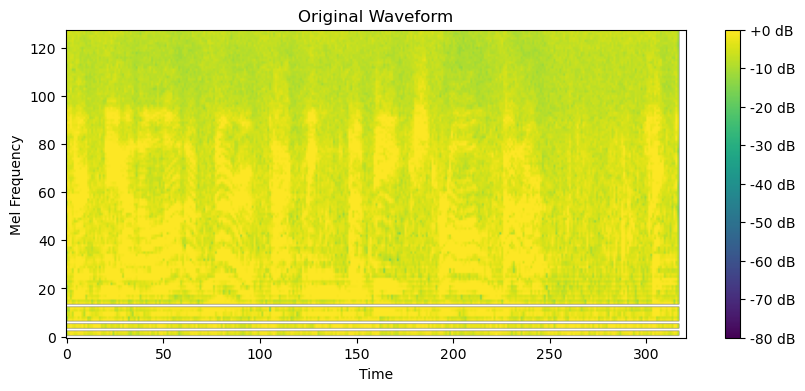

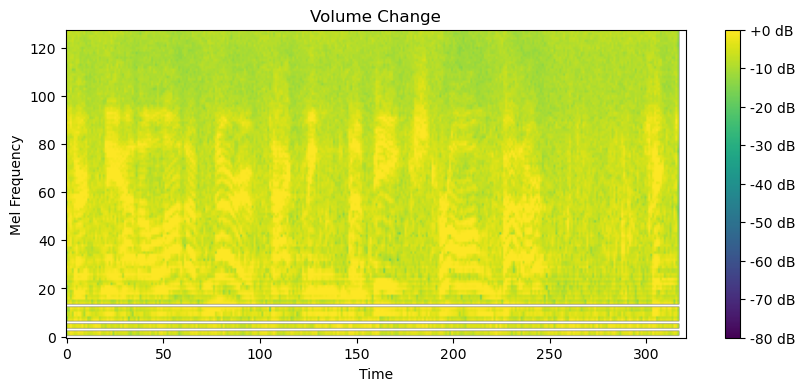

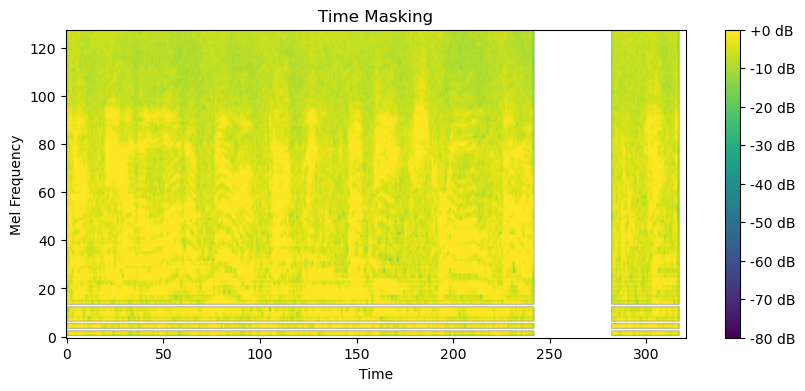

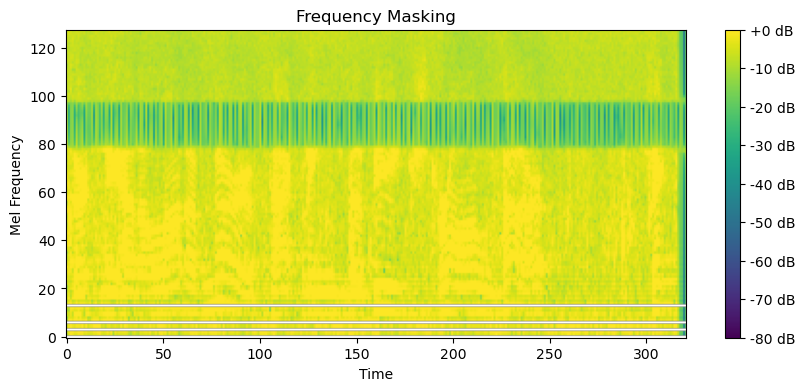

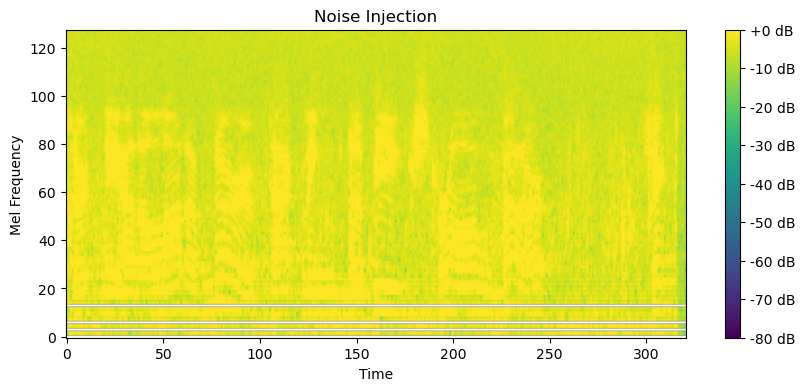

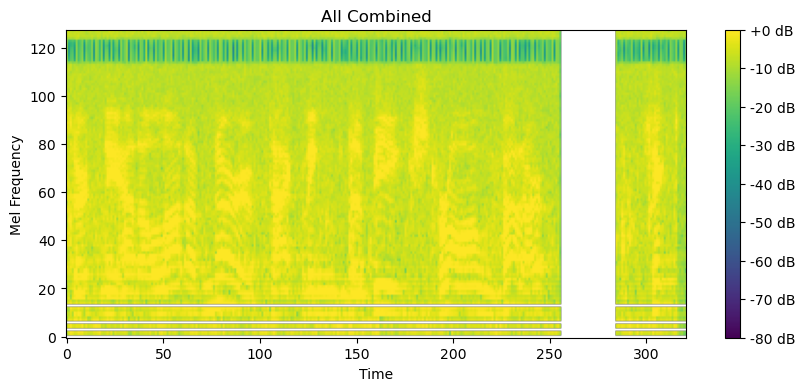

In [274]:

# Load a sample audio file
try:
    waveform, sample_rate = torchaudio.load(torchaudio.utils.download_asset("/home/hp4ran/DeepFakeProject/Real/Peoples speech Splits/Test/peoples_speech_Test_2090_1.wav"))
except Exception as e:
    print(f"Error loading audio file: {e}")
    exit(1)

# Generate augmented waveforms
augmented_waveforms = augment_audio(waveform, sample_rate)

# Plot original spectrogram
plot_spectrogram(waveform, sample_rate, title="Original Waveform")

# Plot spectrograms for each augmentation
for name, aug_waveform in augmented_waveforms.items():
        plot_spectrogram(aug_waveform, sample_rate, title=name)
